import Libararies and set constant values

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import json
import random
import glob
import math , cv2
RANDOM_SEED_VAL = 42
random.seed(RANDOM_SEED_VAL)
tf.random.set_seed(RANDOM_SEED_VAL)
np.random.seed(RANDOM_SEED_VAL)
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))


GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Functions

In [2]:
def prepare(ds, shuffle=False, augment=False):
    """Prepares a TensorFlow dataset for image classification.

    Resizes/rescales images, applies optional data augmentation, shuffles (optional),
    and prefetches data. Requires `train_aug` and `val_aug` functions for augmentation.

    Args:
      ds: TensorFlow dataset.
      shuffle: Shuffle data (default: False).
      augment: Apply data augmentation (default: False).

    Returns:
       TensorFlow dataset.
    """
    # Resize and rescale all datasets.
    if augment:
        ds = ds.map(lambda x, y: (train_aug(x, training=True), y),
                      num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (val_aug(x), y),
                      num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

      # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


def update_model_history(total_history ,history):
    """Updates a total model history dictionary with entries from a new history.

    This function iterates through the keys (metrics) in the `history` dictionary,
    which is assumed to contain training or evaluation metrics from a TensorFlow model.
    For each metric:

    1. It checks if the key exists in the `total_history.history` dictionary.
     - If the key doesn't exist, it creates a new list for that metric in
       `total_history.history`.
    2. It appends the values of the metric from the `history` dictionary to the
     corresponding list in `total_history.history`. This effectively accumulates
     training or evaluation history across multiple training epochs.

    Args:
      total_history: Dictionary containing the accumulated model history (metrics).
      history: Dictionary containing metrics from a single training or evaluation run.

    Returns:
      None (modifies the `total_history` dictionary in-place).
    """
    # Iterate through metrics (keys) in the history
    for key in history.history:
        # Check if the metric exists in total history (and create an empty list if not)
        if total_history.history.get(key) == None:
            total_history.history.update({key:[]})
        total_history.history[key] += history.history[key]

def base_mode_finetune(model, tune_percentage):
    """Fine-tunes a specified percentage of layers at the end of the model's 'base_model'.

    Args:
        model: A TensorFlow model with a layer named 'base_model'.
        tune_percentage: A float between 0 and 1, indicating the proportion of
            layers in 'base_model' to fine-tune (e.g., 0.25 for fine-tuning 25%).

    Returns:
        The compiled model with specified layers fine-tuned.
    """

    # Freeze all layers in the 'base_model' initially.
    model.get_layer('base_model').trainable = False

    # Calculate the number of layers to fine-tune.
    num_layers = len(model.get_layer('base_model').layers)
    num_layers_fine_tune = int(num_layers * tune_percentage)

    # Unfreeze the specified number of layers from the end of 'base_model'.
    for model_layer in model.get_layer('base_model').layers[-num_layers_fine_tune:]:
        model_layer.trainable = True

    print(f"Trainable layers: {num_layers_fine_tune} of {num_layers} convolutional layers")

    # Compile the model with fine-tuned layers.
    model.compile(optimizer=optimizer, loss=loss_fun, metrics=model_metrics)

    return model

def matric_plot(history, keys, labels, title):
    """
    Plots metrics (loss, accuracy, etc.) from a TensorFlow training history.

    This function creates a single subplot and plots the provided metrics (specified by their keys in the history object)
    against their corresponding epochs. It also sets labels and a title for the plot.

    Args:
        history (tensorflow.keras.callbacks.History): The training history object obtained from training a model.
        keys (list): A list of strings containing the names of the metrics to plot.
                These keys should correspond to entries in the `history.history` dictionary.
        labels (list): A list of strings containing labels for each metric line in the plot.
                The length of this list should match the length of the `keys` list.
        title (str): The title to display for the plot.
    """

    plt.figure(figsize=(8, 2))  # Create a figure with specified size
    plt.subplot(1, 1, 1)        # Create a single subplot within the figure

    # Loop through metrics and plot them
    for idx, key in enumerate(keys):
        data_list = history.history[key]
        plt.plot(range(len(data_list)), data_list, label=labels[idx])

    # Add labels, title, and display the plot
    plt.legend()
    plt.title(title)
    plt.show()


## The Dataset

### Load & Create The Dataset



In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


set the dataset loading pramters

In [6]:
data_dir = "/content/drive/MyDrive/images"
# data_dir = "/content/drive/MyDrive/processed_data"
batch_size = 16
img_size = (224 ,224)
validation_split = .2

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = validation_split,
    subset = "training",
    seed = RANDOM_SEED_VAL,
    image_size = img_size,
    batch_size = batch_size )

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = validation_split,
    subset="validation",
    seed = RANDOM_SEED_VAL,
    image_size = img_size,
    batch_size = batch_size)

Found 70 files belonging to 6 classes.
Using 56 files for training.
Found 70 files belonging to 6 classes.
Using 14 files for validation.


## Standardize & augment  the data

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
# Augmantions for training data
train_aug = tf.keras.Sequential([
    #layers.RandomRotation((-0.30,0.30)),
    #layers.RandomZoom(height_factor= 0.2, fill_value =255 ),
    #layers.RandomWidth(0.2),
   # layers.Resizing(height=  img_size[0] , width= img_size[1]),
    #layers.Rescaling(1./255),
])
# Augmantions for Val data
val_aug = tf.keras.Sequential([
    #layers.Resizing(height=  img_size[0] , width= img_size[1]),
    #layers.Rescaling(1./255)
])

train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

## The Model



In [22]:
num_classes = 6
epochs = 20
inatial_epochs =0
base_learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model_metrics = ['accuracy'  ]
total_history = keras.callbacks.History()

#checkpoint_filepath = './checkpoint/best_model_{epoch:02d}_{val_accuracy:.2f}.hdf5'
checkpoint_filepath = 'models/best_model.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
def make_model(base_model , preprocess):
    img_size = (224 ,224)
    base_model = base_model(
                             # input_shape=(IMG_SIZE,IMG_SIZE,3,16) ,
                              pooling=None,
                             # include_preprocessing=True ,
                              include_top= False,
                              classes=num_classes,
                              classifier_activation=None
                              )
    base_model.trainable = False
    #base_model.summary()
    base_model._name = "base_model"
    inputs =  tf.keras.Input(shape=(img_size[0], img_size[1], 3),name='Input')
    x = preprocess(inputs)
    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D(name = 'head_GAvgPool2D') (x)
    x = tf.keras.layers.Dropout(0.4 , name ='head_Dropout')(x)
    outputs =  tf.keras.layers.Dense(num_classes ,name = 'Output')(x)
    model = tf.keras.Model(inputs, outputs)
    return  model

model = make_model(tf.keras.applications.vgg16.VGG16 ,
                  tf.keras.applications.vgg16.preprocess_input )
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 base_model (Functional)     (None, None, None, 512)   14714688  
                                                                 
 head_GAvgPool2D (GlobalAve  (None, 512)               0         
 ragePooling2D)                                                  
                                                           

In [24]:
num_layers = len(model.get_layer('base_model').layers)
print(f"base model layes {num_layers}")

base model layes 19


check model output shape

In [25]:
image_batch, label_batch = next(iter(val_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(14, 6)


### Compile the model


In [26]:
model.compile(optimizer = optimizer,
              loss = loss_fun,
              metrics = model_metrics )

### finetune the model

In [27]:
history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs =  inatial_epochs +epochs ,
        initial_epoch = inatial_epochs,
         callbacks=[model_checkpoint_callback] )

update_model_history(total_history ,history)
inatial_epochs += epochs

Epoch 1/20
4/4 [==============================] - 15s 2s/step - loss: 15.2488 - accuracy: 0.1607 - val_loss: 15.0004 - val_accuracy: 0.1429
Epoch 2/20
4/4 [==============================] - 3s 245ms/step - loss: 13.5657 - accuracy: 0.1250 - val_loss: 11.3643 - val_accuracy: 0.1429
Epoch 3/20
4/4 [==============================] - 3s 308ms/step - loss: 9.9538 - accuracy: 0.2143 - val_loss: 9.1168 - val_accuracy: 0.2143
Epoch 4/20
4/4 [==============================] - 3s 585ms/step - loss: 9.0976 - accuracy: 0.2143 - val_loss: 7.7513 - val_accuracy: 0.2857
Epoch 5/20
4/4 [==============================] - 3s 256ms/step - loss: 8.1613 - accuracy: 0.2500 - val_loss: 6.6466 - val_accuracy: 0.2857
Epoch 6/20
4/4 [==============================] - 3s 301ms/step - loss: 7.9454 - accuracy: 0.2143 - val_loss: 5.6765 - val_accuracy: 0.3571
Epoch 7/20
4/4 [==============================] - 3s 321ms/step - loss: 5.1978 - accuracy: 0.3214 - val_loss: 4.9104 - val_accuracy: 0.4286
Epoch 8/20
4/4 [==

In [28]:

epochs=20
base_learning_rate = 7e-5
tune_percentage = 1


base_mode_finetune(model ,tune_percentage )

history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs =  inatial_epochs +epochs ,
        initial_epoch = inatial_epochs,
        callbacks=[model_checkpoint_callback]
)

update_model_history(total_history ,history)
inatial_epochs += epochs


Trainable layers: 19 of 19 convolutional layers
Epoch 21/40
4/4 [==============================] - 4s 323ms/step - loss: 1.1255 - accuracy: 0.7679 - val_loss: 0.8335 - val_accuracy: 0.9286
Epoch 22/40
4/4 [==============================] - 3s 279ms/step - loss: 1.1875 - accuracy: 0.7857 - val_loss: 0.8250 - val_accuracy: 0.9286
Epoch 23/40
4/4 [==============================] - 4s 333ms/step - loss: 1.4587 - accuracy: 0.7500 - val_loss: 0.7902 - val_accuracy: 0.9286
Epoch 24/40
4/4 [==============================] - 2s 250ms/step - loss: 1.5650 - accuracy: 0.7321 - val_loss: 0.7506 - val_accuracy: 0.9286
Epoch 25/40
4/4 [==============================] - 2s 269ms/step - loss: 0.6875 - accuracy: 0.8036 - val_loss: 0.7169 - val_accuracy: 0.9286
Epoch 26/40
4/4 [==============================] - 2s 283ms/step - loss: 0.7412 - accuracy: 0.8750 - val_loss: 0.6853 - val_accuracy: 0.9286
Epoch 27/40
4/4 [==============================] - 3s 279ms/step - loss: 0.9449 - accuracy: 0.7857 - val_l

In [29]:
print(f'Max val Accuracy :{max(total_history.history["val_accuracy"])}')

Max val Accuracy :0.9285714030265808


## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

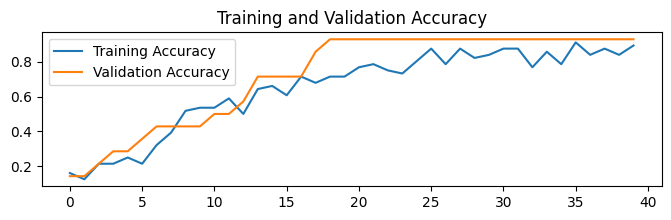

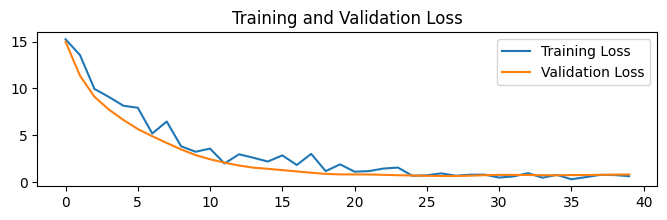

In [30]:
matric_plot(total_history,[ 'accuracy', 'val_accuracy'] , ['Training Accuracy' ,'Validation Accuracy' ], 'Training and Validation Accuracy' )
matric_plot(total_history,[ 'loss', 'val_loss'] , ['Training Loss' ,'Validation Loss' ], 'Training and Validation Loss' )